##### Download, normalize and split vol cube data into train/test datasets

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, uniq_opt_tenors, uniq_swap_tenors, uniq_strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test indexes
MIN_IDX1 = 0   # first period of high vols
MAX_IDX1 = 100 # first period of high vols
MIN_IDX2 = 850 # second period of high vols
MAX_IDX2 = 950 # second period of high vols

date_idx = 145 # has the largest value (vol=246bp)

all_indexes = [*range(data.shape[0])]
test_indexes = [*range(MIN_IDX1, MAX_IDX1)] +[*range(MIN_IDX2, MAX_IDX2)]  # vols are huge here
train_indexes = [i for i in all_indexes if i not in test_indexes]

# Create train and test datasets for normalized data
data_norm_train = data_norm[train_indexes]
data_norm_test = data_norm[test_indexes]
# Create train and test datasets for non-normalized data
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

### Let's train vae on small vol values and check whether generating vol cubes can predict large vol values

##### Let's check what period volatilities were high

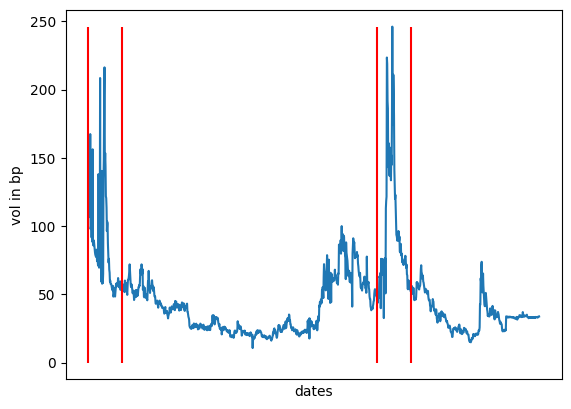

In [9]:
import matplotlib.pyplot as plt
plt.plot(data[:,0,0,0]) # huge values are in the interval [:100, 850:950]
plt.ylabel('vol in bp')
plt.xlabel('dates')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ymax=data[:,0,0,0].max()
# First period of huge values
plt.vlines(x=MIN_IDX1, ymin=0,ymax=ymax, color='red')
plt.vlines(x=MAX_IDX1, ymin=0,ymax=ymax, color='red')
# Second period of huge values
plt.vlines(x=MIN_IDX2, ymin=0,ymax=ymax, color='red')
plt.vlines(x=MAX_IDX2, ymin=0,ymax=ymax, color='red')
plt.show()

Train VAE (it takes 10 minutes)

In [3]:
# EPOCHS = 3000
# BATCH_SIZE = 16
# HIDDEN_LAYERS_NODES =  [400, 200, 200, 100]
# LOSS_TYPE = 'mse'  # or 'bce'
# BETA = 2e-6
# seed = 0

# # Create the name of the model based on characteristics
# NAME = 'vol_cube_vae_van_2latd_' 
# for i, nodes in enumerate(HIDDEN_LAYERS_NODES):
#     NAME += str(nodes) + '_'
# NAME += str(EPOCHS) + 'ep_bat' + str(BATCH_SIZE) +'_' + str(BETA)
# NAME += '_seed' + str(seed) + 'train_on_small_vols'
# print(NAME)


# # Create VAE and fit it
# from src.models.vae_vanilla import VaeVanilla
# vae = VaeVanilla(input_shape=data_norm_train.shape[1:],
#                  hidden_layers_nodes=HIDDEN_LAYERS_NODES, # best [400, 200, 200, 100] or a bit worse [400, 200, 100, 50]
#                  latent_space_dim=2,
#                  loss_type=LOSS_TYPE,  
#                  beta=BETA)
# vae.compile(optimizer='adam')
# history = vae.fit(data_norm_train, 
#                   epochs=EPOCHS, 
#                   verbose=0,
#                   batch_size=BATCH_SIZE,
#                   validation_data=data_norm_test)  # add validation_data=data_norm_test worse results

# from src.utils.save_model_and_history import save_model_and_history
# save_model_and_history(vae, 
#                        history, 
#                        NAME,
#                        data_type='vol')

##### Load the model and history of training process

In [4]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vol_cube_vae_van_2latd_400_200_200_100_3000ep_bat16_2e-06_seed0train_on_small_vols'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Check that trained model is pretty good

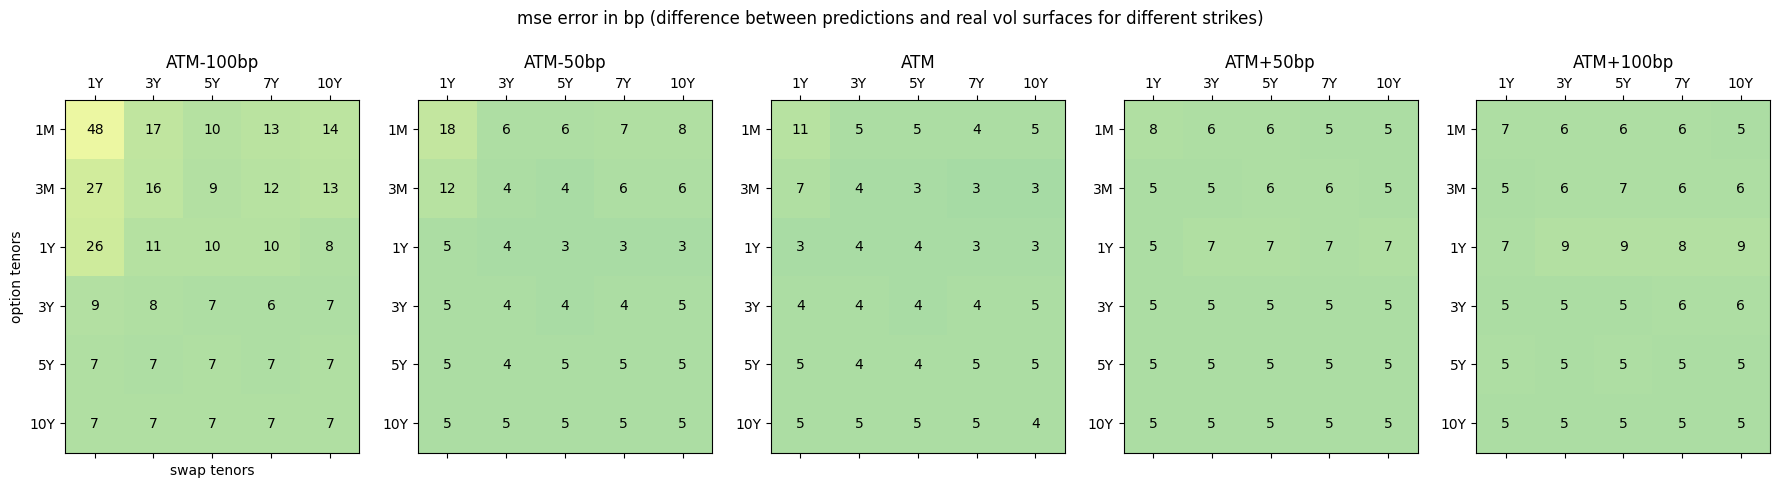

In [5]:
from src.visualization.vol.error_vol_cube_grids import error_vol_cube_grids

strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
error_vol_cube_grids(predictions,
                     data_test,
                     x_labels=uniq_swap_tenors,
                     y_labels=uniq_opt_tenors,
                     uniq_strikes=uniq_strikes,
                     strikes=strikes,
                     error_type='mse'
                     )

1 test dataset vol cube that we would like to find among many generated vol cubes

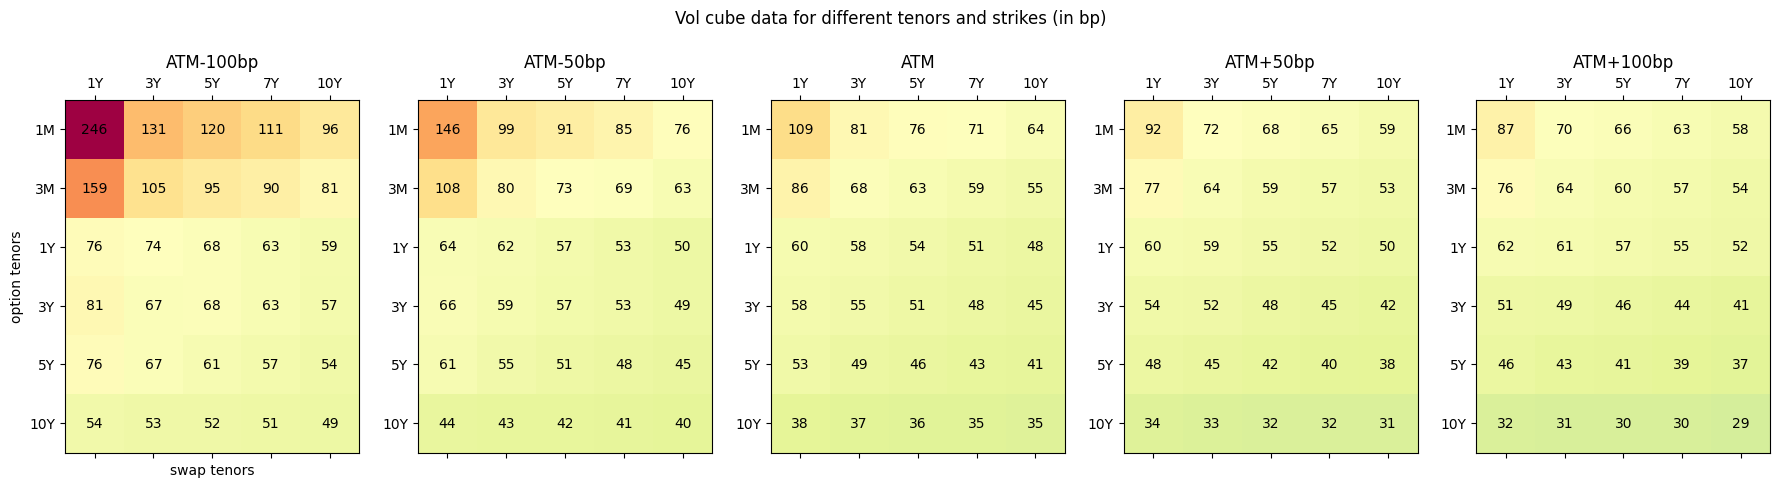

In [6]:
from src.visualization.vol.vol_cube_grids import vol_cube_grids

vol_cube_grids(data=data_test[date_idx],
                x_labels=uniq_swap_tenors,
                y_labels=uniq_opt_tenors,
                uniq_strikes=uniq_strikes,
                strikes=strikes)

##### Let's find among 100,000 generated vol cubes the vol cube which is similar to vol cube above. And access the error

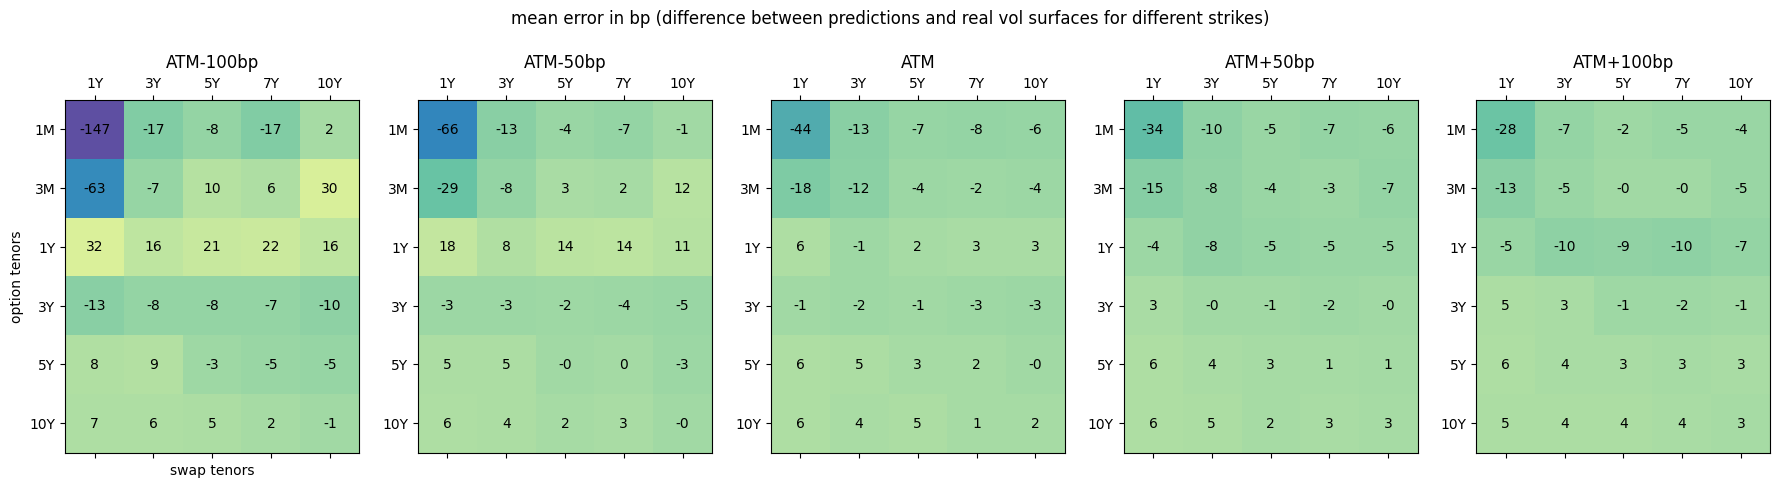

In [7]:
import numpy as np
from src.visualization.vol.vol_cube_grids import vol_cube_grids
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

N = 100_000

latent_space_dim = vae.encoder.predict(x=data_norm_test, verbose=0)[0].shape[1]
mean = np.zeros(latent_space_dim)
cov = np.eye(latent_space_dim) * 16
np.random.seed(0)
z_initial = np.random.multivariate_normal(mean, cov, N)

gen_vol_cubes = normalizer.denormalize(vae.decoder.predict(np.array(z_initial), verbose=0))

mse_optimal = float('inf')

for i in range(N):
    diff = data_test[date_idx] - gen_vol_cubes[i]
    mse = (diff**2).mean()
    if mse < mse_optimal:
        id_best = i
        mse_optimal = mse

from src.visualization.vol.error_vol_cube_grids import error_vol_cube_grids
error_vol_cube_grids(predictions=np.expand_dims(gen_vol_cubes[id_best],0),  # not normalized
                        data=np.expand_dims(data_test[date_idx],0),          # not normalized
                        x_labels=uniq_swap_tenors,
                        y_labels=uniq_opt_tenors,
                        uniq_strikes=uniq_strikes, 
                        strikes=strikes, 
                        error_type='mean',
                        save_name=NAME
                        )